In [3]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [11]:
path = '/home/shady/Projects/GML/Project_3/Graph Processor/CA-HepTh(corrected_index).csv'

df = pd.read_csv(path)
df

,From,To
0,3521,3524
1,3521,5739
2,3521,8396
3,3524,522
4,3524,549
...,...,...
51966,8919,9199
51967,2020,2871
51968,2020,5504
51969,2871,2020


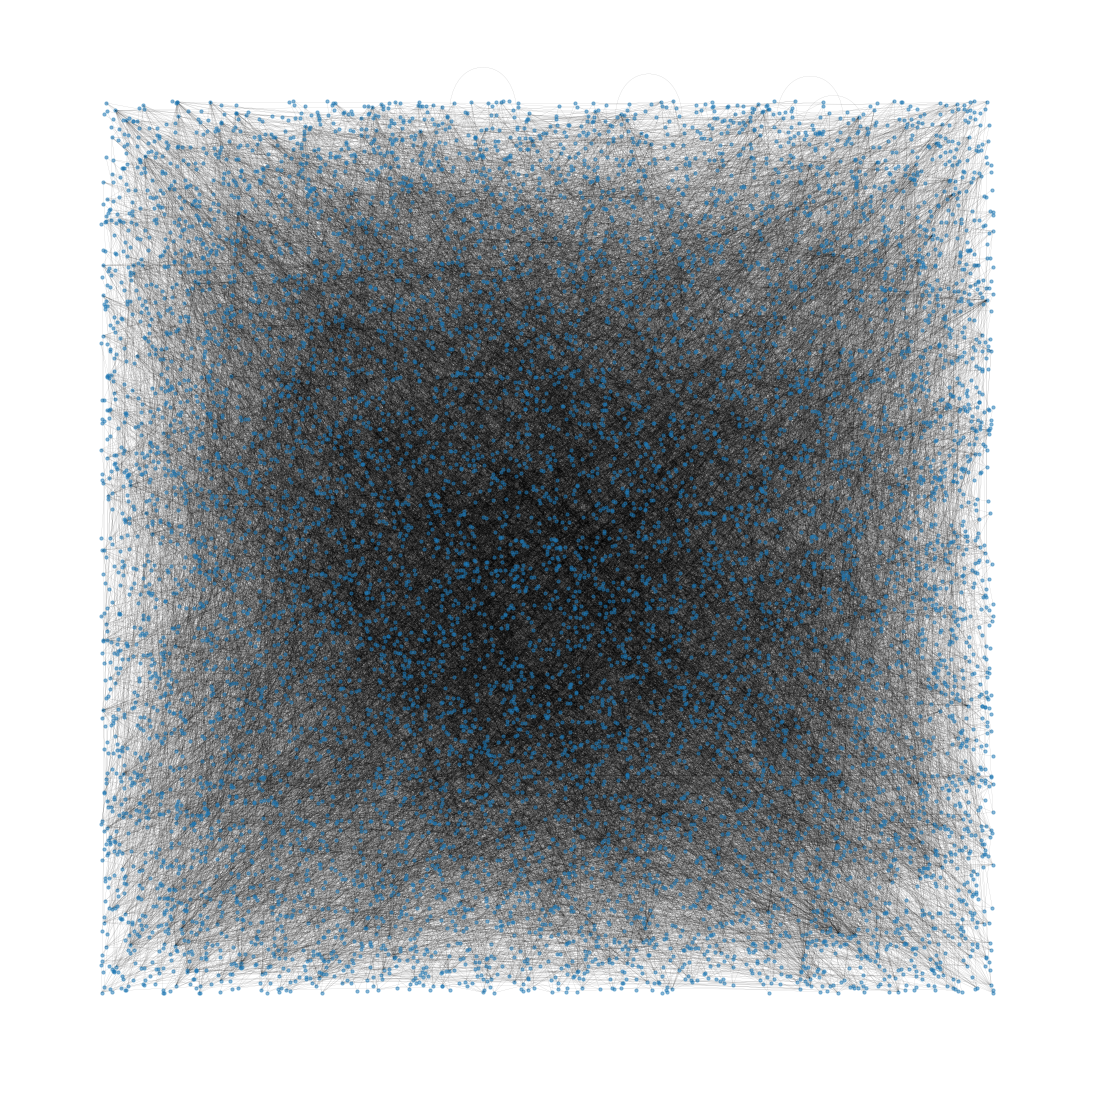

In [12]:
G = nx.from_pandas_edgelist(df,'From','To')

plt.figure(figsize=(15,15))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 10, alpha = 0.5, width = 0.1)

plt.show()

In [4]:
node_list = df['From'].tolist() + df['To'].tolist()

node_list = list(dict.fromkeys(node_list))

adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [5]:
adj_G.shape

(9877, 9877)

In [6]:
all_unconnected_pairs = []
 
# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
    for j in range(offset,adj_G.shape[1]):
        if i != j:
            if adj_G[i,j] == 0:
                all_unconnected_pairs.extend([(node_list[i],node_list[j])])
 
    offset = offset + 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9877/9877 [00:50<00:00, 194.53it/s]


In [7]:
len(all_unconnected_pairs)

48746653

In [8]:
unconnected_sample = sorted(random.sample(all_unconnected_pairs, k=1000000))

In [9]:
negative_sample = [(i[0],i[1]) for i in unconnected_sample if nx.has_path(G, i[0], i[1]) and nx.shortest_path_length(G, i[0], i[1]) <= 7]

In [10]:
len(negative_sample)

660596

In [24]:
df1 = pd.DataFrame(data = negative_sample, columns =['From', 'To'])
 
df1['Connection'] = 0
 
df1.head()

,From,To,Connection
0,0,79,0
1,0,500,0
2,0,749,0
3,0,1043,0
4,0,1222,0


In [17]:
# Create a list of all indices of the node pairs in the fb dataframe,
# which when removed won’t change the structure of our graph
 
# create a copy
df_temp = df.copy()
 
# for storing removable edges
removable_edges_indices = []
 
# number of connected components and nodes of G
ncc = nx.number_connected_components(G)
number_of_nodes = len(G.nodes)
 
# for each node pair we will be removing a node pair and creating a new graph,
# and check if the number of connected components and the number of nodes
# are the same as the original graph
for i in tqdm(df.index.values):
  
    # remove a node pair and build a new graph
    G1 = nx.from_pandas_edgelist(df_temp.drop(index= i), "From", "To", create_using=nx.Graph())
  
    # If the number of connected components remain same as the original
    # graph we won't remove the edge
    if (nx.number_connected_components(G1) == ncc) and (len(G1.nodes) == number_of_nodes):
        removable_edges_indices.append(i)
 
        # drop the edge, so that for the next iteration the next G1
        # is created without this edge
        df_temp = df_temp.drop(index = i)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51971/51971 [2:29:30<00:00,  5.79it/s]


In [18]:
import pickle

with open('removable_edges_indices.pkl', 'wb') as f:
    pickle.dump(removable_edges_indices, f)

In [20]:
df2 = df.loc[removable_edges_indices]
 
df2['Connection'] = 1
 
df2.head()

,From,To,Connection
0,3521,3524,1
1,3521,5739,1
2,3521,8396,1
3,3524,522,1
4,3524,549,1


In [25]:
df1 = df1.append(df2[['From', 'To', 'Connection']],ignore_index=True)
df1.head()

,From,To,Connection
0,0,79,0
1,0,500,0
2,0,749,0
3,0,1043,0
4,0,1222,0


In [26]:
df3 = df.drop(index=df2.index.values)
df3.head()

,From,To
243,9333,8222
477,7442,6234
667,5917,4437
1054,5620,1829
1595,1224,1573


In [27]:
G_new = nx.from_pandas_edgelist(df3, "From", "To", create_using=nx.Graph())

print(nx.info(G_new))

Graph with 9877 nodes and 9450 edges


In [50]:
df1.to_csv('df1.csv')
df2.to_csv('df2.csv')
df3.to_csv('df3.csv')

# Node2Vec

In [13]:
from node2vec import Node2Vec
 
# Generating walks
node2vec = Node2Vec(G, dimensions=128, walk_length=16, num_walks=50, workers=8)
 
# training the node2vec model
n2v_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/9877 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


In [14]:
edge_features = [(n2v_model[str(i)]+n2v_model[str(j)]) for i,j in zip(df1['From'], df1['To'])]

/tmp/ipykernel_115574/1329011645.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  edge_features = [(n2v_model[str(i)]+n2v_model[str(j)]) for i,j in zip(df1['From'], df1['To'])]


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

In [17]:
X = np.array(edge_features)  

y = df1['Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [18]:
# classifier
clf3 = MLPClassifier(max_iter=50, verbose=True)
 
# scaling training and test sets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# parameters
# param = {'hidden_layer_sizes' : [10,100,[10,10]], 'activation' : ['tanh'], 'solver' : ['adam']}
 
# model
# grid_clf_acc3 = GridSearchCV(clf3, param_grid = param)
 
# train the model
clf3.fit(X_train_scaled, y_train)
 
# print('Grid best parameter (max. accuracy): ', grid_clf_acc3.best_params_)
# print('Grid best score (accuracy): ', grid_clf_acc3.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
# grid_clf_auc3 = GridSearchCV(clf3, param_grid = param, scoring = 'roc_auc')
# grid_clf_auc3.fit(X_train_scaled, y_train)
predict_proba = clf3.predict_proba(X_test_scaled)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
# print('Grid best parameter (max. AUC): ', grid_clf_auc3.best_params_)
# print('Grid best score (AUC): ', grid_clf_auc3.best_score_)

Iteration 1, loss = 0.43476894
Iteration 2, loss = 0.35506111
Iteration 3, loss = 0.30245253
Iteration 4, loss = 0.26409456
Iteration 5, loss = 0.23341647
Iteration 6, loss = 0.20883152
Iteration 7, loss = 0.18567757
Iteration 8, loss = 0.16707440
Iteration 9, loss = 0.15301017
Iteration 10, loss = 0.13914318
Iteration 11, loss = 0.12947128
Iteration 12, loss = 0.11988920
Iteration 13, loss = 0.11143581
Iteration 14, loss = 0.10456702
Iteration 15, loss = 0.09966350
Iteration 16, loss = 0.09426829
Iteration 17, loss = 0.09026233
Iteration 18, loss = 0.08566818
Iteration 19, loss = 0.08140011
Iteration 20, loss = 0.07854364
Iteration 21, loss = 0.07572529
Iteration 22, loss = 0.07351367
Iteration 23, loss = 0.07057938
Iteration 24, loss = 0.06898143
Iteration 25, loss = 0.06773531
Iteration 26, loss = 0.06451362
Iteration 27, loss = 0.06281862
Iteration 28, loss = 0.06111817
Iteration 29, loss = 0.05874353
Iteration 30, loss = 0.05874576
Iteration 31, loss = 0.05673387
Iteration 32, los

/home/shady/Projects/miniconda3/envs/GML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
pred = clf3.predict(X_test_scaled)

accuracy_score(pred,y_test)

0.9838304943913585

In [20]:
confusion_matrix(pred,y_test)

array([[49243,   638],
       [  335,  9959]])

In [21]:
predict_proba = clf3.predict_proba(X_test_scaled)[:,1]
 
false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

Text(0, 0.5, 'True Positive Rate')

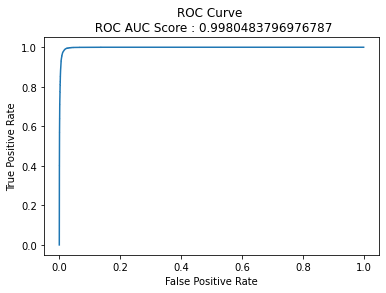

In [22]:
plt.plot(false_positive_rate,true_positive_rate)
plt.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [23]:
df1.head()

,From,To,Connection
2,0,749,0
4,0,1222,0
5,0,1536,0
8,0,2127,0
12,0,3780,0


In [24]:
print(f' ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair features : {X[4]}')

# its position in X_train
print(f'Index of ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair in X_train : {np.where(X_train == X[4])[0][1]}')

 (0,3780) node pair features : [ 2.65354514e-01  9.24888611e-01  2.42566198e-01  1.62686259e-01
 -7.23956704e-01 -6.74386263e-01 -5.07505953e-01  5.25791466e-01
  7.75394738e-01  4.68173742e-01  1.02359879e+00 -1.11334229e+00
  9.50363338e-01 -7.72034347e-01  3.43324900e-01 -1.25640380e+00
 -9.36376095e-01 -4.94375527e-01  1.71068037e+00 -5.16579390e-01
  3.37397456e-01  4.34826940e-01  3.89844924e-02  1.16344666e+00
 -6.59037471e-01  6.33070052e-01 -9.01009023e-01 -1.16949129e+00
 -5.06743729e-01  3.61080259e-01  1.95840883e+00 -1.50734138e+00
 -1.09118365e-01  1.40653759e-01  1.98684081e-01  7.32515216e-01
  5.40696263e-01  2.88942814e-01  4.33556736e-02 -8.11780035e-01
 -9.11400676e-01 -5.84242165e-01  3.25436443e-01 -5.67130968e-02
 -9.40767229e-01 -4.47077364e-01  5.13732433e-04  9.10654664e-03
  7.51853883e-01 -5.12844920e-01  1.08357370e+00 -1.88061118e-01
  2.74458855e-01 -5.50237715e-01 -1.00384462e+00 -2.48767920e-02
  1.14174068e+00 -3.94935250e-01 -5.21209478e-01  1.0555493

In [25]:
predict_proba = clf3.predict_proba(X_train_scaled[np.where(X_train == X[4])[0][1]].reshape(1,-1))[:,1]
 
print(f'Probability of nodes {df1.iloc[4,0]} and {df1.iloc[4,1]} to form a link is : {float(predict_proba)*100 : .2f}%')

Probability of nodes 0 and 3780 to form a link is :  0.07%


# SPLITTER

In [8]:
train_path = '/home/shady/Projects/GML/Project_3/df1.csv'
embeddings_path = '/home/shady/Projects/GML/Project_3/Splitter/output/CA-HepTh_embedding.csv'

df1 = pd.read_csv(train_path)

split_vecs = pd.read_csv(embeddings_path)
split_vecs

,id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127
0,0.0,0.281146,0.026628,-0.075055,0.766695,-0.037459,0.360209,0.256439,0.260366,0.210113,...,-0.056171,0.189333,-0.092432,0.125194,-0.383738,0.035863,-0.245163,0.152364,-0.242185,-0.631613
1,1.0,0.124271,1.963735,1.004305,4.517806,0.504425,1.705830,4.060788,1.813375,2.541965,...,-0.075472,0.050662,5.018387,0.855350,-4.912320,-1.286528,-1.876461,-0.354446,0.306086,-3.704297
2,2.0,-1.474192,4.342272,1.459642,13.988391,-0.337841,6.853401,9.598235,7.316743,5.789269,...,1.329487,2.071156,15.255783,4.343288,-15.687894,-2.101721,-7.262014,0.677078,-1.035133,-9.649491
3,3.0,-1.089224,2.162391,1.014160,5.274250,0.182775,3.223264,4.409286,3.420423,2.815713,...,1.011179,1.168930,6.095719,2.253143,-6.905834,-0.366037,-2.484507,0.686045,-0.784882,-3.525471
4,4.0,-0.315469,1.274243,0.760735,4.937324,0.380760,2.556359,2.732485,1.874178,2.284877,...,0.233032,0.358024,5.283386,1.743315,-5.780168,-1.054922,-3.059674,-0.047908,-0.791628,-2.834863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17424,17424.0,-0.827051,1.088520,0.139678,5.128009,-0.438969,1.954270,2.924335,2.683857,1.781407,...,0.721555,0.972377,5.394748,1.071934,-5.644707,-0.436048,-2.708851,-0.182712,0.101964,-3.002874
17425,17425.0,-0.806445,1.067219,0.153925,5.086170,-0.440602,1.970162,3.683392,2.714458,1.774912,...,0.033587,0.962314,5.752304,1.072312,-5.298505,-0.278273,-2.186146,-0.002315,0.119459,-2.976145
17426,17426.0,-0.968427,1.221131,0.094665,4.412745,-0.449089,2.890141,3.103696,2.332314,2.576499,...,0.869023,0.246130,5.850725,2.021258,-5.876999,-0.297578,-3.057146,0.581456,0.114596,-3.877030
17427,17427.0,-1.028707,1.235617,0.080158,4.709956,-0.485761,3.050214,3.228297,2.402486,2.704488,...,0.922004,0.234613,6.132371,2.117864,-5.550348,-0.297217,-3.176149,0.618651,0.124466,-4.047583


In [9]:
df1 = df1.drop(df1.query('Connection == 0').sample(frac=.7).index)
df1 = df1.drop(columns=['Unnamed: 0'])
df1.to_csv('df1_sampled.csv')
df1

,From,To,Connection
2,0,749,0
4,0,1222,0
5,0,1536,0
8,0,2127,0
12,0,3780,0
...,...,...,...
703112,721,9311,1
703113,7874,6689,1
703114,7874,8734,1
703115,2020,2871,1


In [39]:
edge_features = [split_vecs.loc[i][1:]*split_vecs.loc[j][1:] for i,j in zip(df1['From'], df1['To'])]

In [40]:
len(edge_features)

240700

In [41]:
X = np.array(edge_features)  

y = df1['Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [42]:
# classifier
clf3 = MLPClassifier(max_iter=200, verbose=True)
 
# scaling training and test sets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# parameters
# param = {'hidden_layer_sizes' : [10,100,[10,10]], 'activation' : ['tanh'], 'solver' : ['adam']}
 
# model
# grid_clf_acc3 = GridSearchCV(clf3, param_grid = param)
 
# train the model
clf3.fit(X_train_scaled, y_train)
 
# print('Grid best parameter (max. accuracy): ', grid_clf_acc3.best_params_)
# print('Grid best score (accuracy): ', grid_clf_acc3.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
# grid_clf_auc3 = GridSearchCV(clf3, param_grid = param, scoring = 'roc_auc')
# grid_clf_auc3.fit(X_train_scaled, y_train)
predict_proba = clf3.predict_proba(X_test_scaled)[:,1]
 
print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
# print('Grid best parameter (max. AUC): ', grid_clf_auc3.best_params_)
# print('Grid best score (AUC): ', grid_clf_auc3.best_score_)

Iteration 1, loss = 0.46930377
Iteration 2, loss = 0.46690767
Iteration 3, loss = 0.46625378
Iteration 4, loss = 0.46564198
Iteration 5, loss = 0.46559875
Iteration 6, loss = 0.46539483
Iteration 7, loss = 0.46550770
Iteration 8, loss = 0.46507825
Iteration 9, loss = 0.46499694
Iteration 10, loss = 0.46475568
Iteration 11, loss = 0.46466490
Iteration 12, loss = 0.46442483
Iteration 13, loss = 0.46412878
Iteration 14, loss = 0.46403489
Iteration 15, loss = 0.46398061
Iteration 16, loss = 0.46370232
Iteration 17, loss = 0.46349042
Iteration 18, loss = 0.46324401
Iteration 19, loss = 0.46299809
Iteration 20, loss = 0.46267340
Iteration 21, loss = 0.46227518
Iteration 22, loss = 0.46209068
Iteration 23, loss = 0.46182509
Iteration 24, loss = 0.46145273
Iteration 25, loss = 0.46139354
Iteration 26, loss = 0.46079025
Iteration 27, loss = 0.46054855
Iteration 28, loss = 0.46033277
Iteration 29, loss = 0.46033257
Iteration 30, loss = 0.45981006
Iteration 31, loss = 0.45938465
Iteration 32, los

/home/shady/Projects/miniconda3/envs/GML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


TypeError: 'numpy.float64' object is not callable

In [ ]:
pred = clf3.predict(X_test_scaled)

accuracy_score(pred,y_test)

In [ ]:
confusion_matrix(pred,y_test)

In [ ]:
predict_proba = clf3.predict_proba(X_test_scaled)[:,1]
 
false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

In [ ]:
plt.plot(false_positive_rate,true_positive_rate)
plt.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
df1.head()

In [ ]:
print(f' ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair features : {X[4]}')

# its position in X_train
print(f'Index of ({df1.iloc[4,0]},{df1.iloc[4,1]}) node pair in X_train : {np.where(X_train == X[4])[0][1]}')

In [ ]:
predict_proba = clf3.predict_proba(X_train_scaled[np.where(X_train == X[4])[0][1]].reshape(1,-1))[:,1]
 
print(f'Probability of nodes {df1.iloc[4,0]} and {df1.iloc[4,1]} to form a link is : {float(predict_proba)*100 : .2f}%')